In [1]:
import pandas as pd
import micom
from gurobipy import *
import numpy as np
from micom import load_pickle
from micom.media import minimal_medium
from micom.workflows import workflow

import cobra
# https://resendislab.github.io/micom/media.html

In [2]:
#Load pickle

#In this case we only use one model to turn off each reaction and see what happends

com = load_pickle("./models/community_6_Jun7.pickle")
com2 = load_pickle("./models/community_19_Jun7.pickle")

Academic license - for non-commercial use only - expires 2021-07-16
Using license file C:\Users\santi\gurobi\gurobi.lic
Read LP format model from file C:\Users\santi\AppData\Local\Temp\tmpivoyg4br.lp
Reading time = 0.17 seconds
: 3200 rows, 7779 columns, 30399 nonzeros
Read LP format model from file C:\Users\santi\AppData\Local\Temp\tmpl2ps3y0k.lp
Reading time = 0.19 seconds
: 3200 rows, 7779 columns, 30399 nonzeros


In [3]:
#This next section is meant to remove each reaction and check for biomass production

In [4]:
sol = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
sol2 = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
sol

,abundance,growth_rate,reactions,metabolites
compartments,,,,
A,0.090226,0.005849,1431,1166
B,0.390977,0.025348,872,713
C,0.518797,0.033637,1462,1193
medium,NaN,NaN,124,124


In [5]:
sol2

,abundance,growth_rate,reactions,metabolites
compartments,,,,
A,0.573913,0.037436,1431,1166
B,0.273913,0.017866,872,713
C,0.152174,0.009925,1462,1193
medium,NaN,NaN,124,124


In [6]:
goal=sol.growth_rate
goalA = sol.members.growth_rate['A']
goalB = sol.members.growth_rate['B']
goalC = sol.members.growth_rate['C']
goal, goalA, goalB, goalC

(0.0278892797561983,
 0.00584881536058049,
 0.025348199390182805,
 0.033637420830186275)

In [7]:
goal2=sol2.growth_rate
goal2A = sol2.members.growth_rate['A']
goal2B = sol2.members.growth_rate['B']
goal2C = sol2.members.growth_rate['C']
goal2, goal2A, goal2B, goal2C

(0.02788927975615532,
 0.03743635966879882,
 0.017865974463978782,
 0.009925097649966146)

In [9]:
only_med = [0]*len(com.medium)
#print(len(only_med))
c=0
for r in com.reactions:
    if r.id in com.medium:
        only_med[c]=r
        c+=1
        #print(c, end=', ')
        if c==len(only_med):
            break

In [10]:
only_med2 = [0]*len(com2.medium)
#print(len(only_med))
c=0
for r in com2.reactions:
    if r.id in com2.medium:
        only_med2[c]=r
        c+=1
        #print(c, end=', ')
        if c==len(only_med2):
            break

In [18]:
#Test all variable/non-variable reactions that we got from the 256 sample analysis

In [11]:
shared = {'3HCO3_NAt': 1, 'AGPAT1': 1,'ATPS4m': 1,'CYOOm3': 1,'CYOR_u10m': 1,'EX_hco3_LPAREN_e_RPAREN_': 1,'EX_hco3_b': 1,
 'EX_leu_L_LPAREN_e_RPAREN_': 1,'EX_leu_L_b': 1,'EX_nh4_LPAREN_e_RPAREN_': 1,'EX_nh4_b': 1,'EX_o2_LPAREN_e_RPAREN_': 1,
 'EX_o2_b': 1,'EX_pi_LPAREN_e_RPAREN_': 1,'EX_pi_b': 1,'EX_ser_L_LPAREN_e_RPAREN_': 1,'EX_ser_L_b': 1,'G3PD1': 1,'GPAM_hs': 1,
 'O2t': 1,'O2tm': 1,'PPM': 1,'RE3273C': 1,'RE3301C': 1,'TKT1': 1,'TKT2': 1,'r0838': 1,'r2136': 1}

shared_n = {'ACt2r': 1,
 'EX_urea_LPAREN_e_RPAREN_': 1,
 'EX_urea_b': 1,
 'RETNt': 1,
 'UREAt5': 1,
 'UREAtm': 1,
 'r1427': 1,
 'r2114': 1,
 'D_LACt2': 1,
 'EX_lac_D_LPAREN_e_RPAREN_': 1,
 'EX_lac_D_b': 1,
 'LDH_D': 1,
 'r0839': 1,
 'r1992': 1}

shared_reac = {}
for r in com.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in shared:
        if temp[0] not in shared_reac:
            shared_reac[temp[0]]=[]
        shared_reac[temp[0]].append(r)
        
shared_n_reac = {}
for r in com.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in shared_n:
        if temp[0] not in shared_n_reac:
            shared_n_reac[temp[0]]=[]
        shared_n_reac[temp[0]].append(r)

In [12]:
shared_reac2 = {}
for r in com2.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in shared:
        if temp[0] not in shared_reac2:
            shared_reac2[temp[0]]=[]
        shared_reac2[temp[0]].append(r)
        
shared_n_reac2 = {}
for r in com2.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in shared_n:
        if temp[0] not in shared_n_reac2:
            shared_n_reac2[temp[0]]=[]
        shared_n_reac2[temp[0]].append(r)

In [13]:
shared_50=[]
for ra in shared_reac.keys():
    t_u=[0]*len(shared_reac[ra])
    t_l=[0]*len(shared_reac[ra])
    for i,r in enumerate(shared_reac[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal*0.6 and (sol_i.members.growth_rate['A']< goalA*0.7 or sol_i.members.growth_rate['B']< goalB*0.7 or sol_i.members.growth_rate['C']< goalC*0.7):
            print(ra, end=' - ')
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal*0.5:
            shared_50.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(shared_reac[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
shared_50

EX_leu_L_b - Growth:  0.0 0.0 0.0 0.0

EX_o2_b - Growth:  0.010043041709867095 0.0021055420129850217 0.009127348563430036 0.01211356393610323

EX_pi_b - Growth:  0.0 0.0 0.0 0.0

AGPAT1 - Growth:  0.0 0.0 0.0 0.0

GPAM_hs - Growth:  0.0 0.0 0.0 0.0

PPM - Growth:  0.0 0.0 0.0 0.0

RE3273C - Growth:  0.0 0.0 0.0 0.0

RE3301C - Growth:  0.0 0.0 0.0 0.0

CYOR_u10m - Growth:  0.01664200585663885 0.0034896839548776157 0.015125296857127416 0.020072393106600667

O2t - Growth:  0.011041313450342486 0.0023149309173893045 0.01003470040552519 0.013317552026087084

EX_leu_L_LPAREN_e_RPAREN_ - Growth:  0.0 0.0 0.0 0.0

EX_o2_LPAREN_e_RPAREN_ - Growth:  0.010043041709841903 0.002105542017108041 0.009127348562977975 0.012113563935678306

EX_pi_LPAREN_e_RPAREN_ - Growth:  0.0 0.0 0.0 0.0



['EX_leu_L_b__C',
 'EX_o2_b__C',
 'EX_pi_b__C',
 'AGPAT1__C',
 'GPAM_hs__C',
 'PPM__C',
 'RE3273C__C',
 'RE3301C__C',
 'O2t__C',
 'EX_leu_L_LPAREN_e_RPAREN___C',
 'EX_o2_LPAREN_e_RPAREN___C',
 'EX_pi_LPAREN_e_RPAREN___C']

In [14]:
shared_502=[]
for ra in shared_reac2.keys():
    t_u=[0]*len(shared_reac2[ra])
    t_l=[0]*len(shared_reac2[ra])
    for i,r in enumerate(shared_reac2[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal2*0.6 and (sol_i.members.growth_rate['A']< goal2A*0.7 or sol_i.members.growth_rate['B']< goal2B*0.7 or sol_i.members.growth_rate['C']< goal2C*0.7):
            print(ra, end=' - ')
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal2*0.5:
            shared_502.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(shared_reac2[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
shared_502

EX_leu_L_b - Growth:  0.0 0.0 0.0 0.0

EX_o2_b - Growth:  0.010043041709837986 0.01348145862436142 0.006432969300667233 0.003573427650845609

EX_pi_b - Growth:  0.0 0.0 0.0 0.0

AGPAT1 - Growth:  0.0 0.0 0.0 0.0

GPAM_hs - Growth:  0.0 0.0 0.0 0.0

PPM - Growth:  0.0 0.0 0.0 0.0

RE3273C - Growth:  0.0 0.0 0.0 0.0

RE3301C - Growth:  0.0 0.0 0.0 0.0

CYOR_u10m - Growth:  0.016642005856590307 0.022339209637021972 0.01066052644552943 0.005922070681655849

O2t - Growth:  0.011041313450351645 0.014821432948305364 0.00707250161750995 0.003928723407907131

EX_leu_L_LPAREN_e_RPAREN_ - Growth:  0.0 0.0 0.0 0.0

EX_o2_LPAREN_e_RPAREN_ - Growth:  0.010043041709842222 0.01348145862350665 0.006432969300156355 0.0035734276550167224

EX_pi_LPAREN_e_RPAREN_ - Growth:  0.0 0.0 0.0 0.0



['EX_leu_L_b__C',
 'EX_o2_b__C',
 'EX_pi_b__C',
 'AGPAT1__C',
 'GPAM_hs__C',
 'PPM__C',
 'RE3273C__C',
 'RE3301C__C',
 'O2t__C',
 'EX_leu_L_LPAREN_e_RPAREN___C',
 'EX_o2_LPAREN_e_RPAREN___C',
 'EX_pi_LPAREN_e_RPAREN___C']

In [15]:
shared_n_50=[]
for ra in shared_n_reac.keys():
    t_u=[0]*len(shared_n_reac[ra])
    t_l=[0]*len(shared_n_reac[ra])
    
    for i,r in enumerate(shared_n_reac[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal*0.6 and (sol_i.members.growth_rate['A']< goalA*0.7 or sol_i.members.growth_rate['B']< goalB*0.7 or sol_i.members.growth_rate['C']< goalC*0.7):
            print(ra, end=' - ')
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal*0.5:
            shared_n_50.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(shared_n_reac[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
shared_n_50

[]

In [16]:
shared_n_502=[]
for ra in shared_n_reac2.keys():
    t_u=[0]*len(shared_n_reac2[ra])
    t_l=[0]*len(shared_n_reac2[ra])
    
    for i,r in enumerate(shared_n_reac2[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal2*0.6 and (sol_i.members.growth_rate['A']< goal2A*0.7 or sol_i.members.growth_rate['B']< goal2B*0.7 or sol_i.members.growth_rate['C']< goal2C*0.7):
            print(ra, end=' - ')
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal2*0.5:
            shared_n_502.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(shared_n_reac2[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
shared_n_502

[]

In [22]:
#Only A

In [17]:
A_only={'ATPtm': 1, 'EX_glu_L_LPAREN_e_RPAREN_': 1, 'EX_glu_L_b': 1, 'FADH2ETC': 1, 'FUMm': 1, 'GLUB0AT3tc': 1, 'MALtm': 1, 
        'MDH': 1, 'NADH2_u10m': 1, 'NICRNS': 1, 'NP1': 1, 'OAADC': 1, 'RPE': 1, 'SUCD1m': 1, 'SUCOASm': 1, 'r0249': 1, 
        'r0391': 1, 'r0840': 1, 'r0841': 1, 'ARGN': 1,'ARGNm': 1,'INSTt2r': 1,'ORNTArm': 1,'VALATB0tc': 1,'r0821': 1,'r1144': 1,
        'r2084': 1, 'r2407': 1}

pop_reac = {}
for r in com.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in A_only:
        if temp[0] not in pop_reac:
            pop_reac[temp[0]]=[]
        pop_reac[temp[0]].append(r)
        
pop_50=[]
for ra in pop_reac.keys():
    t_u=[0]*len(pop_reac[ra])
    t_l=[0]*len(pop_reac[ra])
    
    for i,r in enumerate(pop_reac[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal*0.6 and (sol_i.members.growth_rate['A']< goalA*0.7 or sol_i.members.growth_rate['B']< goalB*0.7 or sol_i.members.growth_rate['C']< goalC*0.7):
            print(ra,end=' - ')
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal*0.5:
            pop_50.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(pop_reac[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
pop_50

NICRNS - Growth:  0.0 0.0 0.0 0.0

NP1 - Growth:  0.0 0.0 0.0 0.0

r0391 - Growth:  0.0 0.0 0.0 0.0



2021-06-07 13:41:53.688 | WARNING  | micom.solution:solve:208 - solver encountered an error infeasible
2021-06-07 13:45:23.785 | WARNING  | micom.solution:solve:208 - solver encountered an error infeasible


Error ['EX_txa2_m']
--------------------------



['NICRNS__C', 'NP1__C', 'r0391__C']

In [18]:
pop_reac2 = {}
for r in com2.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in A_only:
        if temp[0] not in pop_reac2:
            pop_reac2[temp[0]]=[]
        pop_reac2[temp[0]].append(r)
        
pop_502=[]
for ra in pop_reac2.keys():
    t_u=[0]*len(pop_reac2[ra])
    t_l=[0]*len(pop_reac2[ra])
    
    for i,r in enumerate(pop_reac2[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal2*0.6 and (sol_i.members.growth_rate['A']< goal2A*0.7 or sol_i.members.growth_rate['B']< goal2B*0.7 or sol_i.members.growth_rate['C']< goal2C*0.7):
            print(ra,end=' - ')
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal2*0.5:
            pop_502.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(pop_reac2[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
pop_502

NICRNS - Growth:  0.0 0.0 0.0 0.0

NP1 - Growth:  0.0 0.0 0.0 0.0

r0391 - Growth:  0.0 0.0 0.0 0.0



['NICRNS__C', 'NP1__C', 'r0391__C']

In [19]:
#Only B
A_only={'EX_asp_L_LPAREN_e_RPAREN_': 1, 'EX_asp_L_b': 1, 'FBA': 1, 'LEUB0AT3tc': 1, 'PROtm': 1, 'SUCCt2m': 1, 'TPI': 1, 
        'XYLK': 1, 'XYLTD_Dr': 1, 'r0191': 1, 'r0407': 1, 'r0408': 1, 'r0911': 1, 'r0941': 1, 'r1143': 1, 'ACt2m': 1,
        'ACt2r': 1,'AGMTm': 1,'ARGDCm': 1,'ARGtm': 1,'CYSB0AT3tc': 1,'DM_Lcystin': 1,'D_LACt2': 1,'EX_Lcystin_b': 1,
        'EX_ac_LPAREN_e_RPAREN_': 1,'EX_ac_b': 1,'EX_lac_D_LPAREN_e_RPAREN_': 1,'EX_lac_D_b': 1,'EX_ptrc_LPAREN_e_RPAREN_': 1,
        'EX_ptrc_b': 1,'ILEB0AT2tc': 1,'LDH_D': 1,'LEUB0AT2tc': 1,'PTCRTD': 1,'r0027': 1,'r0062': 1,'r0330': 1,'r0907': 1,
        'r2000': 1,'r2093': 1,'r2101': 1,'r2105': 1,'r2114': 1,'r2405': 1,'r2416': 1}

pop_reac = {}
for r in com.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in A_only:
        if temp[0] not in pop_reac:
            pop_reac[temp[0]]=[]
        pop_reac[temp[0]].append(r)
        
pop_50=[]
for ra in pop_reac.keys():
    t_u=[0]*len(pop_reac[ra])
    t_l=[0]*len(pop_reac[ra])
    #print(ra)
    for i,r in enumerate(pop_reac[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal*0.6 and (sol_i.members.growth_rate['A']< goalA*0.7 or sol_i.members.growth_rate['B']< goalB*0.7 or sol_i.members.growth_rate['C']< goalC*0.7):
            print(ra)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'],end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal*0.5:
            pop_50.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(pop_reac[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
pop_50

[]

In [20]:
#Only B
pop_reac2 = {}
for r in com2.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in A_only:
        if temp[0] not in pop_reac2:
            pop_reac2[temp[0]]=[]
        pop_reac2[temp[0]].append(r)
        
pop_502=[]
for ra in pop_reac2.keys():
    t_u=[0]*len(pop_reac2[ra])
    t_l=[0]*len(pop_reac2[ra])
    #print(ra)
    for i,r in enumerate(pop_reac2[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal2*0.6 and (sol_i.members.growth_rate['A']< goal2A*0.7 or sol_i.members.growth_rate['B']< goal2B*0.7 or sol_i.members.growth_rate['C']< goal2C*0.7):
            print(ra)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'],end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal2*0.5:
            pop_502.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(pop_reac2[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
pop_502

[]

In [21]:
#Only C
A_only={'ACCOACm': 1, 'ADSL1': 1, 'ADSL2': 1, 'ADSS': 1, 'AICART': 1, 'AIRCr_PRASCS': 1, 'ALATA_L': 1, 'ARTPLM3': 1, 'ASNS1': 1,
        'C14STRr': 1, 'C3STDH1Pr': 1, 'C3STKR2r': 1, 'C4STMO1r': 1, 'C4STMO2Pr': 1, 'CDIPTr': 1, 'CHOLtu': 1, 'CHSTEROLtrc': 1, 
        'CLS_hs': 1, 'CTPS1': 1, 'CYStec': 1, 'DAGK_hs': 1, 'DATPtn': 1, 'DCTPtn': 1, 'DGTPtn': 1, 'DHCR72r': 1, 'DHCRD1': 1, 
        'DMATT': 1, 'DNDPt19m': 1, 'DPMVDc': 1, 'DSAT': 1, 'DTMPK': 1, 'DTTPtn': 1, 'EX_biomass_c': 1, 'EX_chol_LPAREN_e_RPAREN_': 1, 
        'EX_chol_b': 1, 'EX_cys_L_LPAREN_e_RPAREN_': 1, 'EX_cys_L_b': 1, 'EX_inost_LPAREN_e_RPAREN_': 1, 'EX_inost_b': 1, 
        'EX_lys_L_LPAREN_e_RPAREN_': 1, 'EX_lys_L_b': 1, 'EX_met_L_LPAREN_e_RPAREN_': 1, 'EX_met_L_b': 1, 'EX_phe_L_LPAREN_e_RPAREN_': 1, 
        'EX_phe_L_b': 1, 'EX_thr_L_LPAREN_e_RPAREN_': 1, 'EX_thr_L_b': 1, 'EX_trp_L_LPAREN_e_RPAREN_': 1, 'EX_trp_L_b': 1, 
        'EX_tyr_L_LPAREN_e_RPAREN_': 1, 'EX_tyr_L_b': 1, 'FAS100COA': 1, 'FAS120COA': 1, 'FAS140COA': 1, 'FAS160COA': 1, 
        'FAS80COA_L': 1, 'FDH': 1, 'FORtr': 1, 'FRDPtcr': 1, 'G5SADrm': 1, 'GARFT': 1, 'GHMT2r': 1, 'GK1': 1, 'GLUDym': 1, 
        'GLUPRT': 1, 'GRTT': 1, 'HMGCOARc': 1, 'IMPC': 1, 'INSTt4': 1, 'IPDDI': 1, 'LNSTLSr': 1, 'LSTO2r': 1, 'METtec': 1, 
        'MEVK1c': 1, 'NDPK1': 1, 'NDPK1m': 1, 'O2ter': 1, 'OMPDC': 1, 'ORPT': 1, 'P5CRm': 1, 'PE_HStm': 1, 'PGPPT': 1, 
        'PGPP_hs': 1, 'PHEtec': 1, 'PIt2m': 1, 'PMEVKc': 1, 'PRAGSr': 1, 'PRFGS': 1, 'PSDm_hs': 1, 'PSFLIPm': 1, 'PSSA1_hs': 1, 
        'RE2954C': 1, 'RNDR1': 1, 'RNDR4': 1, 'SERPT': 1, 'SMS': 1, 'SQLEr': 1, 'SQLSr': 1, 'TMDS': 1, 'TRDR': 1, 'TYRt': 1, 
        'UMPK4': 1, 'URIDK2m': 1, 'biomass_DNA': 1, 'biomass_RNA': 1, 'biomass_carbohydrate': 1, 'biomass_lipid': 1, 
        'biomass_other': 1, 'biomass_protein': 1, 'biomass_reaction': 1, 'r0280': 1, 'r0431': 1, 'r0432': 1, 'r0472': 1, 
        'r0474': 1, 'r0666': 1, 'r0781': 1, 'r0801': 1, 'r0818': 1, 'r0853': 1, 'r1005': 1, 'r2526': 1, 'r2534': 1,'ACACtx': 1,'COAtp': 1,
        'CRNCARtp': 1,'CSNATp': 1,'CSNATr': 1, 'FUMTSULtm': 1, 'GALt2_2': 1, 'GLYSNAT5tc': 1, 'HMGCOAtx': 1, 'HMGLx': 1,'KCC2t': 1,
        'L_LACt2r': 1,'MALTSULtm': 1,'NAt5': 1,'PGI': 1,'RDH1': 1,'RDH1a': 1,'RDH2': 1,'RDH2a': 1,'RDH3': 1,'RDH3a': 1,
        'TRPB0AT3tc': 1,'r1380': 1,'r1992': 1,'r2086': 1,'r2473': 1,'r2521': 1}

pop_reac = {}
for r in com.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in A_only:
        if temp[0] not in pop_reac:
            pop_reac[temp[0]]=[]
        pop_reac[temp[0]].append(r)
        
pop_50=[]
for ra in pop_reac.keys():
    t_u=[0]*len(pop_reac[ra])
    t_l=[0]*len(pop_reac[ra])
    print(ra)
    for i,r in enumerate(pop_reac[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal*0.6 and (sol_i.members.growth_rate['A']< goalA*0.7 or sol_i.members.growth_rate['B']< goalB*0.7 or sol_i.members.growth_rate['C']< goalC*0.7):
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal*0.5:
            pop_50.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(pop_reac[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
pop_50

EX_biomass_c
Growth:  0.0 0.0 0.0 0.0

EX_chol_b
EX_cys_L_b
EX_inost_b
Growth:  0.0 0.0 0.0 0.0

EX_lys_L_b
Growth:  0.0 0.0 0.0 0.0

EX_met_L_b
Growth:  0.0 0.0 0.0 0.0

EX_phe_L_b
Growth:  0.0 0.0 0.0 0.0

EX_thr_L_b
Growth:  0.0 0.0 0.0 0.0

EX_trp_L_b
Growth:  0.0 0.0 0.0 0.0

EX_tyr_L_b
Growth:  0.0 0.0 0.0 0.0

ACCOACm
ADSL1
Growth:  0.0 0.0 0.0 0.0

ADSL2
Growth:  0.0 0.0 0.0 0.0

ADSS
Growth:  0.0 0.0 0.0 0.0

AICART
Growth:  0.0 0.0 0.0 0.0

ALATA_L
ARTPLM3
ASNS1
Growth:  0.0 0.0 0.0 0.0

C14STRr
Growth:  0.0 0.0 0.0 0.0

C3STDH1Pr
C3STKR2r
Growth:  0.0 0.0 0.0 0.0

C4STMO1r
Growth:  0.0 0.0 0.0 0.0

C4STMO2Pr
CDIPTr
Growth:  0.0 0.0 0.0 0.0

CLS_hs
Growth:  0.0 0.0 0.0 0.0

CSNATp
CSNATr
CTPS1
DAGK_hs
DHCR72r
DHCRD1
DMATT
DSAT
Growth:  0.0 0.0 0.0 0.0

DTMPK
FAS100COA
Growth:  0.0 0.0 0.0 0.0

FAS120COA
Growth:  0.0 0.0 0.0 0.0

FAS140COA
Growth:  0.0 0.0 0.0 0.0

FAS160COA
Growth:  0.0 0.0 0.0 0.0

FAS80COA_L
Growth:  0.0 0.0 0.0 0.0

FDH
G5SADrm
Growth:  0.0 0.0 0.0 0.0

GA

['EX_biomass_c__C',
 'EX_inost_b__C',
 'EX_lys_L_b__C',
 'EX_met_L_b__C',
 'EX_phe_L_b__C',
 'EX_thr_L_b__C',
 'EX_trp_L_b__C',
 'EX_tyr_L_b__C',
 'ADSL1__C',
 'ADSL2__C',
 'ADSS__C',
 'AICART__C',
 'ASNS1__C',
 'C14STRr__C',
 'C3STKR2r__C',
 'C4STMO1r__C',
 'CDIPTr__C',
 'CLS_hs__C',
 'DSAT__C',
 'FAS100COA__C',
 'FAS120COA__C',
 'FAS140COA__C',
 'FAS160COA__C',
 'FAS80COA_L__C',
 'G5SADrm__C',
 'GARFT__C',
 'GLUPRT__C',
 'IMPC__C',
 'LNSTLSr__C',
 'OMPDC__C',
 'ORPT__C',
 'P5CRm__C',
 'PGPP_hs__C',
 'PGPPT__C',
 'PRAGSr__C',
 'PRFGS__C',
 'PSDm_hs__C',
 'RNDR1__C',
 'SERPT__C',
 'SMS__C',
 'SQLEr__C',
 'SQLSr__C',
 'TMDS__C',
 'TRDR__C',
 'r0666__C',
 'r0781__C',
 'HMGCOARc__C',
 'DATPtn__C',
 'DCTPtn__C',
 'DGTPtn__C',
 'FORtr__C',
 'O2ter__C',
 'PE_HStm__C',
 'PSFLIPm__C',
 'CHSTEROLtrc__C',
 'EX_inost_LPAREN_e_RPAREN___C',
 'EX_lys_L_LPAREN_e_RPAREN___C',
 'EX_met_L_LPAREN_e_RPAREN___C',
 'EX_phe_L_LPAREN_e_RPAREN___C',
 'EX_thr_L_LPAREN_e_RPAREN___C',
 'EX_trp_L_LPAREN_e_RPAREN__

In [22]:
#Only C
pop_reac2 = {}
for r in com2.reactions:
    temp = r.id.split('__')
    if '___' in r.id:
        temp[0]+='_'
        temp[1]=temp[1][1:]
    if temp[0] in A_only:
        if temp[0] not in pop_reac2:
            pop_reac2[temp[0]]=[]
        pop_reac2[temp[0]].append(r)
        
pop_502=[]
for ra in pop_reac2.keys():
    t_u=[0]*len(pop_reac2[ra])
    t_l=[0]*len(pop_reac2[ra])
    #print(ra)
    for i,r in enumerate(pop_reac2[ra]):
        t_u[i] = r.upper_bound
        t_l[i] = r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
    try:
        sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal2*0.6 and (sol_i.members.growth_rate['A']< goal2A*0.7 or sol_i.members.growth_rate['B']< goal2B*0.7 or sol_i.members.growth_rate['C']< goal2C*0.7):
            print(ra)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'],end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
            
        if sol_i.growth_rate < goal2*0.5:
            pop_502.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(pop_reac2[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
pop_502

EX_biomass_c
Growth:  0.0 0.0 0.0 0.0

EX_inost_b
Growth:  0.0 0.0 0.0 0.0

EX_lys_L_b
Growth:  0.0 0.0 0.0 0.0

EX_met_L_b
Growth:  0.0 0.0 0.0 0.0

EX_phe_L_b
Growth:  0.0 0.0 0.0 0.0

EX_thr_L_b
Growth:  0.0 0.0 0.0 0.0

EX_trp_L_b
Growth:  0.0 0.0 0.0 0.0

EX_tyr_L_b
Growth:  0.0 0.0 0.0 0.0

ADSL1
Growth:  0.0 0.0 0.0 0.0

ADSL2
Growth:  0.0 0.0 0.0 0.0

ADSS
Growth:  0.0 0.0 0.0 0.0

AICART
Growth:  0.0 0.0 0.0 0.0

ASNS1
Growth:  0.0 0.0 0.0 0.0

C14STRr
Growth:  0.0 0.0 0.0 0.0

C3STKR2r
Growth:  0.0 0.0 0.0 0.0

C4STMO1r
Growth:  0.0 0.0 0.0 0.0

CDIPTr
Growth:  0.0 0.0 0.0 0.0

CLS_hs
Growth:  0.0 0.0 0.0 0.0

DSAT
Growth:  0.0 0.0 0.0 0.0

FAS100COA
Growth:  0.0 0.0 0.0 0.0

FAS120COA
Growth:  0.0 0.0 0.0 0.0

FAS140COA
Growth:  0.0 0.0 0.0 0.0

FAS160COA
Growth:  0.0 0.0 0.0 0.0

FAS80COA_L
Growth:  0.0 0.0 0.0 0.0

G5SADrm
Growth:  0.0 0.0 0.0 0.0

GARFT
Growth:  0.0 0.0 0.0 0.0

GLUPRT
Growth:  0.0 0.0 0.0 0.0

IMPC
Growth:  0.0 0.0 0.0 0.0

LNSTLSr
Growth:  0.0 0.0 0.0 0

['EX_biomass_c__C',
 'EX_inost_b__C',
 'EX_lys_L_b__C',
 'EX_met_L_b__C',
 'EX_phe_L_b__C',
 'EX_thr_L_b__C',
 'EX_trp_L_b__C',
 'EX_tyr_L_b__C',
 'ADSL1__C',
 'ADSL2__C',
 'ADSS__C',
 'AICART__C',
 'ASNS1__C',
 'C14STRr__C',
 'C3STKR2r__C',
 'C4STMO1r__C',
 'CDIPTr__C',
 'CLS_hs__C',
 'DSAT__C',
 'FAS100COA__C',
 'FAS120COA__C',
 'FAS140COA__C',
 'FAS160COA__C',
 'FAS80COA_L__C',
 'G5SADrm__C',
 'GARFT__C',
 'GLUPRT__C',
 'IMPC__C',
 'LNSTLSr__C',
 'OMPDC__C',
 'ORPT__C',
 'P5CRm__C',
 'PGPP_hs__C',
 'PGPPT__C',
 'PRAGSr__C',
 'PRFGS__C',
 'PSDm_hs__C',
 'RNDR1__C',
 'SERPT__C',
 'SMS__C',
 'SQLEr__C',
 'SQLSr__C',
 'TMDS__C',
 'TRDR__C',
 'r0666__C',
 'r0781__C',
 'HMGCOARc__C',
 'DATPtn__C',
 'DCTPtn__C',
 'DGTPtn__C',
 'FORtr__C',
 'O2ter__C',
 'PE_HStm__C',
 'PSFLIPm__C',
 'CHSTEROLtrc__C',
 'EX_inost_LPAREN_e_RPAREN___C',
 'EX_lys_L_LPAREN_e_RPAREN___C',
 'EX_met_L_LPAREN_e_RPAREN___C',
 'EX_phe_L_LPAREN_e_RPAREN___C',
 'EX_thr_L_LPAREN_e_RPAREN___C',
 'EX_trp_L_LPAREN_e_RPAREN__

In [26]:
#Make heatmap

In [ ]:
com

In [ ]:
t_u=0
t_l=0
c=0
only_med_func=[]
only_med_func_great=[]
single_med_50=[]
single_med_50_pop=[]

for r in only_med:
    t_u=r.upper_bound
    t_l=r.lower_bound
    r.upper_bound = 0
    r.lower_bound = 0
    sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
    
    #print('Zero bounds: ', r.lower_bound, r.upper_bound)
    
    if sol_i.growth_rate < goal*0.75 or sol_i.members.growth_rate['A']< goalA*0.6 or sol_i.members.growth_rate['B']< goalB*0.6 or sol_i.members.growth_rate['C']< goalC*0.6:
        print(c, r.id, end=' - ')
        print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
        #print('Original flux: ', sol.fluxes[r.id].medium)
        #print('Flux: ', sol_i.fluxes[r.id].medium)
        #print('Original bounds: ', t_l, t_u, end='\n--------------------------------------------------->\n')
    #else:
        #print('Original bounds: ', t_l, t_u, end='\n-----------------------------\n')
        
    r.upper_bound = t_u
    r.lower_bound = t_l
    if sol_i.growth_rate < goal*0.75 and sol_i.growth_rate > 0 :
        only_med_func.append(r)
    if sol_i.growth_rate > 0 :
        only_med_func_great.append(r)
    if sol_i.growth_rate <= goal*0.5:
        single_med_50.append(r.id)
    if sol_i.members.growth_rate['A']< goalA*0.5:
        single_med_50_pop.append((r.id, sol_i.members.growth_rate['A']))
    if sol_i.members.growth_rate['B']< goalB*0.5:
        single_med_50_pop.append((r.id, sol_i.members.growth_rate['B']))
    if sol_i.members.growth_rate['C']< goalC*0.5:
        single_med_50_pop.append((r.id, sol_i.members.growth_rate['C']))
        
        
    #print('Restored bounds: ', r.lower_bound, r.upper_bound, end='\n\n')
    c+=1

print(single_med_50,end='\n\n\n')
print(single_med_50_pop)

In [ ]:
#check for all medium exchange reactions individually

In [23]:
t_u=0
t_l=0
c=0
only_med_func=[]
only_med_func_great=[]
single_med_50=[]
single_med_50_pop=[]

for r in only_med:
    t_u=r.upper_bound
    t_l=r.lower_bound
    r.upper_bound = 0
    r.lower_bound = 0
    sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
    
    #print('Zero bounds: ', r.lower_bound, r.upper_bound)
    
    if sol_i.growth_rate < goal*0.75 or sol_i.members.growth_rate['A']< goalA*0.6 or sol_i.members.growth_rate['B']< goalB*0.6 or sol_i.members.growth_rate['C']< goalC*0.6:
        print(c, r.id, end=' - ')
        print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
        #print('Original flux: ', sol.fluxes[r.id].medium)
        #print('Flux: ', sol_i.fluxes[r.id].medium)
        #print('Original bounds: ', t_l, t_u, end='\n--------------------------------------------------->\n')
    #else:
        #print('Original bounds: ', t_l, t_u, end='\n-----------------------------\n')
        
    r.upper_bound = t_u
    r.lower_bound = t_l
    if sol_i.growth_rate < goal*0.75 and sol_i.growth_rate > 0 :
        only_med_func.append(r)
    if sol_i.growth_rate > 0 :
        only_med_func_great.append(r)
    if sol_i.growth_rate <= goal*0.5:
        single_med_50.append(r.id)
    if sol_i.members.growth_rate['A']< goalA*0.5:
        single_med_50_pop.append((r.id, sol_i.members.growth_rate['A']))
    if sol_i.members.growth_rate['B']< goalB*0.5:
        single_med_50_pop.append((r.id, sol_i.members.growth_rate['B']))
    if sol_i.members.growth_rate['C']< goalC*0.5:
        single_med_50_pop.append((r.id, sol_i.members.growth_rate['C']))
        
        
    #print('Restored bounds: ', r.lower_bound, r.upper_bound, end='\n\n')
    c+=1

print(single_med_50,end='\n\n\n')
print(single_med_50_pop)

1 EX_arg_L_m - Growth:  0.0 0.0 0.0 0.0

11 EX_his_L_m - Growth:  0.0 0.0 0.0 0.0

12 EX_ile_L_m - Growth:  0.0 0.0 0.0 0.0

13 EX_inost_m - Growth:  0.0 0.0 0.0 0.0

14 EX_leu_L_m - Growth:  0.0 0.0 0.0 0.0

15 EX_lys_L_m - Growth:  0.0 0.0 0.0 0.0

16 EX_met_L_m - Growth:  0.0 0.0 0.0 0.0

19 EX_o2_m - Growth:  0.010054594473570516 0.0021079652427402366 0.009137849130764228 0.01212749740431764

20 EX_phe_L_m - Growth:  0.0 0.0 0.0 0.0

21 EX_pi_m - Growth:  0.0 0.0 0.0 0.0

29 EX_thr_L_m - Growth:  0.0 0.0 0.0 0.0

30 EX_trp_L_m - Growth:  0.0 0.0 0.0 0.0

31 EX_tyr_L_m - Growth:  0.0 0.0 0.0 0.0

32 EX_val_L_m - Growth:  0.0 0.0 0.0 0.0

['EX_arg_L_m', 'EX_his_L_m', 'EX_ile_L_m', 'EX_inost_m', 'EX_leu_L_m', 'EX_lys_L_m', 'EX_met_L_m', 'EX_o2_m', 'EX_phe_L_m', 'EX_pi_m', 'EX_thr_L_m', 'EX_trp_L_m', 'EX_tyr_L_m', 'EX_val_L_m']


[('EX_arg_L_m', 0.0), ('EX_arg_L_m', 0.0), ('EX_arg_L_m', 0.0), ('EX_his_L_m', 0.0), ('EX_his_L_m', 0.0), ('EX_his_L_m', 0.0), ('EX_ile_L_m', 0.0), ('EX_ile_L

In [25]:
t_u=0
t_l=0
c=0
only_med_func2=[]
only_med_func_great2=[]
single_med_502=[]
single_med_50_pop2=[]

for r in only_med2:
    t_u=r.upper_bound
    t_l=r.lower_bound
    r.upper_bound = 0
    r.lower_bound = 0
    sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
    
    #print('Zero bounds: ', r.lower_bound, r.upper_bound)
    
    if sol_i.growth_rate < goal2*0.75 or sol_i.members.growth_rate['A']< goal2A*0.6 or sol_i.members.growth_rate['B']< goal2B*0.6 or sol_i.members.growth_rate['C']< goal2C*0.6:
        print(c, r.id, end=' - ')
        print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
        #print('Original flux: ', sol.fluxes[r.id].medium)
        #print('Flux: ', sol_i.fluxes[r.id].medium)
        #print('Original bounds: ', t_l, t_u, end='\n--------------------------------------------------->\n')
    #else:
        #print('Original bounds: ', t_l, t_u, end='\n-----------------------------\n')
        
    r.upper_bound = t_u
    r.lower_bound = t_l
    if sol_i.growth_rate < goal2*0.75 and sol_i.growth_rate > 0 :
        only_med_func2.append(r)
    if sol_i.growth_rate > 0 :
        only_med_func_great2.append(r)
    if sol_i.growth_rate <= goal2*0.5:
        single_med_502.append(r.id)
    if sol_i.members.growth_rate['A']< goal2A*0.5:
        single_med_50_pop2.append((r.id, sol_i.members.growth_rate['A']))
    if sol_i.members.growth_rate['B']< goal2B*0.5:
        single_med_50_pop2.append((r.id, sol_i.members.growth_rate['B']))
    if sol_i.members.growth_rate['C']< goal2C*0.5:
        single_med_50_pop2.append((r.id, sol_i.members.growth_rate['C']))
        
        
    #print('Restored bounds: ', r.lower_bound, r.upper_bound, end='\n\n')
    c+=1

print(single_med_502,end='\n\n\n')
print(single_med_50_pop2)

1 EX_arg_L_m - Growth:  0.0 0.0 0.0 0.0

11 EX_his_L_m - Growth:  0.0 0.0 0.0 0.0

12 EX_ile_L_m - Growth:  0.0 0.0 0.0 0.0

13 EX_inost_m - Growth:  0.0 0.0 0.0 0.0

14 EX_leu_L_m - Growth:  0.0 0.0 0.0 0.0

15 EX_lys_L_m - Growth:  0.0 0.0 0.0 0.0

16 EX_met_L_m - Growth:  0.0 0.0 0.0 0.0

19 EX_o2_m - Growth:  0.009241699697635088 0.01240582192407557 0.005919597948193389 0.003288221322905173

20 EX_phe_L_m - Growth:  0.0 0.0 0.0 0.0

21 EX_pi_m - Growth:  0.0 0.0 0.0 0.0

29 EX_thr_L_m - Growth:  0.0 0.0 0.0 0.0

30 EX_trp_L_m - Growth:  0.0 0.0 0.0 0.0

31 EX_tyr_L_m - Growth:  0.0 0.0 0.0 0.0

32 EX_val_L_m - Growth:  0.0 0.0 0.0 0.0

['EX_arg_L_m', 'EX_his_L_m', 'EX_ile_L_m', 'EX_inost_m', 'EX_leu_L_m', 'EX_lys_L_m', 'EX_met_L_m', 'EX_o2_m', 'EX_phe_L_m', 'EX_pi_m', 'EX_thr_L_m', 'EX_trp_L_m', 'EX_tyr_L_m', 'EX_val_L_m']


[('EX_arg_L_m', 0.0), ('EX_arg_L_m', 0.0), ('EX_arg_L_m', 0.0), ('EX_his_L_m', 0.0), ('EX_his_L_m', 0.0), ('EX_his_L_m', 0.0), ('EX_ile_L_m', 0.0), ('EX_ile_L_

In [ ]:
#Check for pairs of medium exchange reactions removal

In [26]:
t_u=0
t_l=0
pairs_med_50=[]
pairs_med_50_pop=[]
cou=0

for r in only_med_func:
    c=1
    cou+=1
    t_u=r.upper_bound
    t_l=r.lower_bound
    r.upper_bound = 0
    r.lower_bound = 0
    print(cou, end=':\n')
    for r2 in only_med_func[cou:]:
        t_u2=r2.upper_bound
        t_l2=r2.lower_bound
        r2.upper_bound = 0
        r2.lower_bound = 0
        
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        #print('Zero bounds: ', r.lower_bound, r.upper_bound, r2.lower_bound, r2.upper_bound)
        
        if sol_i.growth_rate < goal*0.6 or sol_i.members.growth_rate['A']< goalA*0.75 or sol_i.members.growth_rate['B']< goalB*0.75 or sol_i.members.growth_rate['C']< goalC*0.75:
            print(c, r.id, r2.id)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            
            #print('Original flux: ', sol.fluxes[r.id].medium, sol.fluxes[r2.id].medium)
            #print('Flux: ', sol_i.fluxes[r.id].medium, sol_i.fluxes[r2.id].medium)
            #print('Original bounds: ', t_l, t_u, t_l2, t_u2, end='\n--------------------------------------------------->\n')
        #else:
            #print('Original bounds: ', t_l, t_u, t_l2, t_u2, end='\n-----------------------------\n')
            
        if sol_i.growth_rate <= goal*0.5:
            pairs_med_50.append((r.id,r2.id))
        
        if sol_i.members.growth_rate['A']< goalA*0.5 or sol_i.members.growth_rate['B']< goalB*0.5 or sol_i.members.growth_rate['C']< goalC*0.5:
            pairs_med_50_pop.append((r.id,r2.id))
            
            
        r2.upper_bound = t_u2
        r2.lower_bound = t_l2
        #print('Restored bounds: ', r2.lower_bound, r2.upper_bound, end='\n\n')
        c+=1
    r.upper_bound = t_u
    r.lower_bound = t_l
    print('----------------------------------------Restored bounds: ', r.lower_bound, r.upper_bound, end='\n\n')
    
print(pairs_med_50)
pairs_med_50_pop

1:
----------------------------------------Restored bounds:  -0.2 10.0

[]


[]

In [27]:
t_u=0
t_l=0
pairs_med_502=[]
pairs_med_50_pop2=[]
cou=0

for r in only_med_func2:
    c=1
    cou+=1
    t_u=r.upper_bound
    t_l=r.lower_bound
    r.upper_bound = 0
    r.lower_bound = 0
    print(cou, end=':\n')
    for r2 in only_med_func2[cou:]:
        t_u2=r2.upper_bound
        t_l2=r2.lower_bound
        r2.upper_bound = 0
        r2.lower_bound = 0
        
        sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        #print('Zero bounds: ', r.lower_bound, r.upper_bound, r2.lower_bound, r2.upper_bound)
        
        if sol_i.growth_rate < goal2*0.6 or sol_i.members.growth_rate['A']< goal2A*0.75 or sol_i.members.growth_rate['B']< goal2B*0.75 or sol_i.members.growth_rate['C']< goal2C*0.75:
            print(c, r.id, r2.id)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            
            #print('Original flux: ', sol.fluxes[r.id].medium, sol.fluxes[r2.id].medium)
            #print('Flux: ', sol_i.fluxes[r.id].medium, sol_i.fluxes[r2.id].medium)
            #print('Original bounds: ', t_l, t_u, t_l2, t_u2, end='\n--------------------------------------------------->\n')
        #else:
            #print('Original bounds: ', t_l, t_u, t_l2, t_u2, end='\n-----------------------------\n')
            
        if sol_i.growth_rate <= goal2*0.5:
            pairs_med_502.append((r.id,r2.id))
        
        if sol_i.members.growth_rate['A']< goal2A*0.5 or sol_i.members.growth_rate['B']< goal2B*0.5 or sol_i.members.growth_rate['C']< goal2C*0.5:
            pairs_med_50_pop2.append((r.id,r2.id))
            
            
        r2.upper_bound = t_u2
        r2.lower_bound = t_l2
        #print('Restored bounds: ', r2.lower_bound, r2.upper_bound, end='\n\n')
        c+=1
    r.upper_bound = t_u
    r.lower_bound = t_l
    print('----------------------------------------Restored bounds: ', r.lower_bound, r.upper_bound, end='\n\n')
    
print(pairs_med_502)
pairs_med_50_pop2

1:
----------------------------------------Restored bounds:  -0.2 10.0

[]


[]

In [28]:
t_u=0
t_l=0
pairs_all_med_50=[]
pairs_all_med_50_pop=[]
for r in only_med_func_great:
    c=1
    t_u=r.upper_bound
    t_l=r.lower_bound
    r.upper_bound = 0
    r.lower_bound = 0
    for r2 in only_med_func_great:
        t_u2=r2.upper_bound
        t_l2=r2.lower_bound
        r2.upper_bound = 0
        r2.lower_bound = 0
        
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        #print('Zero bounds: ', r.lower_bound, r.upper_bound, r2.lower_bound, r2.upper_bound)
        
        if sol_i.growth_rate < goal*0.5 or sol_i.members.growth_rate['A']< goalA*0.4 or sol_i.members.growth_rate['B']< goalB*0.4 or sol_i.members.growth_rate['C']< goalC*0.4:
            print(c, r.id, r2.id)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original flux: ', sol.fluxes[r.id].medium, sol.fluxes[r2.id].medium)
            #print('Flux: ', sol_i.fluxes[r.id].medium, sol_i.fluxes[r2.id].medium)
            #print('Original bounds: ', t_l, t_u, t_l2, t_u2, end='\n--------------------------------------------------->\n')
        #else:
            #print('Original bounds: ', t_l, t_u, t_l2, t_u2, end='\n-----------------------------\n')
            
        if sol_i.growth_rate <= goal*0.5:
            pairs_all_med_50.append((r.id,r2.id))
            
        if sol_i.members.growth_rate['A']< goalA*0.5 or sol_i.members.growth_rate['B']< goalB*0.5 or sol_i.members.growth_rate['C']< goalC*0.5:
            pairs_all_med_50_pop.append((r.id,r2.id))
            
            
        r2.upper_bound = t_u2
        r2.lower_bound = t_l2
        #print('Restored bounds: ', r2.lower_bound, r2.upper_bound, end='\n\n')
        c+=1
    r.upper_bound = t_u
    r.lower_bound = t_l
    print('----------------------------------------Restored bounds: ', r.lower_bound, r.upper_bound, end='\n\n')

print(pairs_all_med_50_pop)
pairs_all_med_50

13 EX_ala_L_m EX_o2_m
Growth:  0.007858882395396428 0.0016474115490227614 0.007142116586393411 0.009479309456868687

----------------------------------------Restored bounds:  -0.2246 10.0

13 EX_asp_L_m EX_o2_m
Growth:  0.009241699697623418 0.001937459409536804 0.008398990619775892 0.011147087373650255

----------------------------------------Restored bounds:  -0.1514 10.0

13 EX_ca2_m EX_o2_m
Growth:  0.01005459447356687 0.002107965235700145 0.009137849131371398 0.012127497405077396

----------------------------------------Restored bounds:  -0.18018 10.0

8 EX_chol_m EX_gal_m
Growth:  0.018510662777355646 0.003881637352187746 0.016823761546361577 0.022326128826359884

13 EX_chol_m EX_o2_m
Growth:  0.008040037784464629 0.0016854091942740666 0.007306772827971598 0.009697795983335391

18 EX_chol_m EX_ser_L_m
Growth:  0.020203805706923903 0.004236776439464149 0.01836269758578075 0.024368181949006654

----------------------------------------Restored bounds:  -0.1428 10.0

13 EX_cl_m EX_o2_

[('EX_ala_L_m', 'EX_o2_m'),
 ('EX_asp_L_m', 'EX_o2_m'),
 ('EX_ca2_m', 'EX_o2_m'),
 ('EX_chol_m', 'EX_o2_m'),
 ('EX_cl_m', 'EX_o2_m'),
 ('EX_cys_L_m', 'EX_o2_m'),
 ('EX_fol_m', 'EX_o2_m'),
 ('EX_gal_m', 'EX_o2_m'),
 ('EX_glu_L_m', 'EX_o2_m'),
 ('EX_gly_m', 'EX_o2_m'),
 ('EX_na1_m', 'EX_o2_m'),
 ('EX_ncam_m', 'EX_o2_m'),
 ('EX_o2_m', 'EX_ala_L_m'),
 ('EX_o2_m', 'EX_asp_L_m'),
 ('EX_o2_m', 'EX_ca2_m'),
 ('EX_o2_m', 'EX_chol_m'),
 ('EX_o2_m', 'EX_cl_m'),
 ('EX_o2_m', 'EX_cys_L_m'),
 ('EX_o2_m', 'EX_fol_m'),
 ('EX_o2_m', 'EX_gal_m'),
 ('EX_o2_m', 'EX_glu_L_m'),
 ('EX_o2_m', 'EX_gly_m'),
 ('EX_o2_m', 'EX_na1_m'),
 ('EX_o2_m', 'EX_ncam_m'),
 ('EX_o2_m', 'EX_o2_m'),
 ('EX_o2_m', 'EX_pnto_R_m'),
 ('EX_o2_m', 'EX_pydxn_m'),
 ('EX_o2_m', 'EX_pyr_m'),
 ('EX_o2_m', 'EX_ribflv_m'),
 ('EX_o2_m', 'EX_ser_L_m'),
 ('EX_o2_m', 'EX_so4_m'),
 ('EX_o2_m', 'EX_thm_m'),
 ('EX_pnto_R_m', 'EX_o2_m'),
 ('EX_pydxn_m', 'EX_o2_m'),
 ('EX_pyr_m', 'EX_o2_m'),
 ('EX_ribflv_m', 'EX_o2_m'),
 ('EX_ser_L_m', 'EX_o2_m'),
 

In [ ]:
t_u=0
t_l=0
pairs_all_med_502=[]
pairs_all_med_50_pop2=[]
for r in only_med_func_great2:
    c=1
    t_u=r.upper_bound
    t_l=r.lower_bound
    r.upper_bound = 0
    r.lower_bound = 0
    for r2 in only_med_func_great2:
        t_u2=r2.upper_bound
        t_l2=r2.lower_bound
        r2.upper_bound = 0
        r2.lower_bound = 0
        
        sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        #print('Zero bounds: ', r.lower_bound, r.upper_bound, r2.lower_bound, r2.upper_bound)
        
        if sol_i.growth_rate < goal2*0.6 or sol_i.members.growth_rate['A']< goal2A*0.75 or sol_i.members.growth_rate['B']< goal2B*0.75 or sol_i.members.growth_rate['C']< goal2C*0.75:
            print(c, r.id, r2.id)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
            #print('Original flux: ', sol.fluxes[r.id].medium, sol.fluxes[r2.id].medium)
            #print('Flux: ', sol_i.fluxes[r.id].medium, sol_i.fluxes[r2.id].medium)
            #print('Original bounds: ', t_l, t_u, t_l2, t_u2, end='\n--------------------------------------------------->\n')
        #else:
            #print('Original bounds: ', t_l, t_u, t_l2, t_u2, end='\n-----------------------------\n')
            
        if sol_i.growth_rate <= goal2*0.5:
            pairs_all_med_502.append((r.id,r2.id))
            
        if sol_i.members.growth_rate['A']< goal2A*0.5 or sol_i.members.growth_rate['B']< goal2B*0.5 or sol_i.members.growth_rate['C']< goal2C*0.5:
            pairs_all_med_50_pop2.append((r.id,r2.id))
            
            
        r2.upper_bound = t_u2
        r2.lower_bound = t_l2
        #print('Restored bounds: ', r2.lower_bound, r2.upper_bound, end='\n\n')
        c+=1
    r.upper_bound = t_u
    r.lower_bound = t_l
    print('----------------------------------------Restored bounds: ', r.lower_bound, r.upper_bound, end='\n\n')

print(pairs_all_med_50_pop2)
pairs_all_med_502

13 EX_ala_L_m EX_o2_m
Growth:  0.007321142460071697 0.009827869165326849 0.004689213103461927 0.002604674144966088

----------------------------------------Restored bounds:  -0.2246 10.0

13 EX_asp_L_m EX_o2_m
Growth:  0.009241699697635088 0.01240582192407557 0.005919597948193389 0.003288221322905173

----------------------------------------Restored bounds:  0 0

13 EX_ca2_m EX_o2_m
Growth:  0.00924169969762206 0.012405821924106003 0.005919597948211445 0.0032882213226722735



In [ ]:
#Check for all other community exchange reactions

In [12]:
t_u=0
t_l=0
ex_50=[]
for r in com.reactions:
    if 'EX_' in r.id and '_m' in r.id and '__' not in r.id and r.id not in com.medium:
        if r.lower_bound!=0 or r.upper_bound!=0:
            t_u=r.upper_bound
            t_l=r.lower_bound
            r.upper_bound = 0
            r.lower_bound = 0
            sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
            #print('Zero bounds: ', r.lower_bound,r.upper_bound)
            if sol_i.growth_rate < goal*0.6 or sol_i.members.growth_rate['A']< goalA*0.8 or sol_i.members.growth_rate['B']< goalB*0.8 or sol_i.members.growth_rate['C']< goalC*0.8:
                print(r.id)
                print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
                #print('Original flux: ', sol.fluxes[r.id].medium)
                #print('Flux: ', sol_i.fluxes[r.id].medium)
                #print('Original bounds: ',r.lower_bound,r.upper_bound, end='\n--------------------------------------------------->\n\n')
            #else:
                #print('Original bounds: ',r.lower_bound,r.upper_bound, end='\n-----------------------------\n\n')
            
            if sol_i.growth_rate < goal*0.5:
                ex_50.append(r.id)
            
            r.upper_bound = t_u
            r.lower_bound = t_l
            
ex_50

[]

In [13]:
t_u=0
t_l=0
ex_502=[]
for r in com2.reactions:
    if 'EX_' in r.id and '_m' in r.id and '__' not in r.id and r.id not in com2.medium:
        if r.lower_bound!=0 or r.upper_bound!=0:
            t_u=r.upper_bound
            t_l=r.lower_bound
            r.upper_bound = 0
            r.lower_bound = 0
            sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
            #print('Zero bounds: ', r.lower_bound,r.upper_bound)
            if sol_i.growth_rate < goal2*0.6 or sol_i.members.growth_rate['A']< goal2A*0.8 or sol_i.members.growth_rate['B']< goal2B*0.8 or sol_i.members.growth_rate['C']< goal2C*0.8:
                print(r.id)
                print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'], end='\n\n')
                #print('Original flux: ', sol.fluxes[r.id].medium)
                #print('Flux: ', sol_i.fluxes[r.id].medium)
                #print('Original bounds: ',r.lower_bound,r.upper_bound, end='\n--------------------------------------------------->\n\n')
            #else:
                #print('Original bounds: ',r.lower_bound,r.upper_bound, end='\n-----------------------------\n\n')
            
            if sol_i.growth_rate < goal2*0.5:
                ex_502.append(r.id)
            
            r.upper_bound = t_u
            r.lower_bound = t_l
            
ex_502

[]

In [ ]:
#check for all reactions related to the mitochondria

In [8]:
d = {}
for r in com.reactions:
    if 'm__' in r.id:
        temp = r.id.split('__')
        if '___' in r.id:
            temp[0]+='_'
            temp[1]=temp[1][1:]
        if temp[0] not in d:
            d[temp[0]]=[]
        d[temp[0]].append(r)

In [9]:
d2 = {}
for r in com2.reactions:
    if 'm__' in r.id:
        temp = r.id.split('__')
        if '___' in r.id:
            temp[0]+='_'
            temp[1]=temp[1][1:]
        if temp[0] not in d2:
            d2[temp[0]]=[]
        d2[temp[0]].append(r)

In [10]:
t_u=0
t_l=0

mito_50=[]

for ra in d:
    t_u=[0]*len(d[ra])
    t_l=[0]*len(d[ra])
    for i,r in enumerate(d[ra]):
        t_u[i] = r.upper_bound
        t_l[i] =r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
        #print('Zero bounds: ', r.lower_bound,r.upper_bound)
    try:
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal*0.95 or sol_i.members.growth_rate['A']< goalA*0.95 or sol_i.members.growth_rate['B']< goalB*0.95 or sol_i.members.growth_rate['C']< goalC*0.95:
            print(ra)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'],end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n--------------------------------------------------->\n')
        #else:
           # print('Original bounds: ',t_l,t_u, end='\n-----------------------------\n')
            
        if sol_i.growth_rate < goal*0.5:
            mito_50.append(r.id)
        
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(d[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
mito_50

ACCOACm
Growth:  0.025907638495352978 0.0 0.0 0.0499379106135748

FUMm
Growth:  0.027058324854995708 0.00880328962928626 0.0 0.05062489337438389

G5SADrm
Growth:  0.0 0.0 0.0 0.0

P5CRm
Growth:  0.0 0.0 0.0 0.0

PDHm
Growth:  0.025484180034171675 0.005344342332269564 0.023162149663133746 0.030736696201790616

ATPS4m
Growth:  0.01840004408557728 0.0038584349296842844 0.01672321770641002 0.022192714664201793

CYOR_u10m
Growth:  0.01664200585663885 0.0034896839548776157 0.015125296857127416 0.020072393106600667

HMGCOAtm
Growth:  0.027447133329677048 0.0 0.025427556802540774 0.03374254725274005

NADH2_u10m
Growth:  0.024302576305669496 0.005096499293428985 0.02208816321528773 0.02931159644254421

O2tm
Growth:  0.021386943691115018 0.004484941291251955 0.019438078553463165 0.025795132131713885

PE_HStm
Growth:  0.0 0.0 0.0 0.0

PSFLIPm
Growth:  0.0 0.0 0.0 0.0



['G5SADrm__C', 'P5CRm__C', 'PE_HStm__C', 'PSFLIPm__C']

In [11]:
t_u=0
t_l=0

mito_502=[]

for ra in d2:
    t_u=[0]*len(d2[ra])
    t_l=[0]*len(d2[ra])
    for i,r in enumerate(d2[ra]):
        t_u[i] = r.upper_bound
        t_l[i] =r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
        #print('Zero bounds: ', r.lower_bound,r.upper_bound)
    try:
        sol_i = com2.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal2*0.95 or sol_i.members.growth_rate['A']< goal2A*0.95 or sol_i.members.growth_rate['B']< goal2B*0.95 or sol_i.members.growth_rate['C']< goal2C*0.95:
            print(ra)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'],end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n--------------------------------------------------->\n')
        #else:
           # print('Original bounds: ',t_l,t_u, end='\n-----------------------------\n')
            
        if sol_i.growth_rate < goal2*0.5:
            mito_502.append(r.id)
        
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(d2[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
mito_502

ACCOACm
Growth:  0.025907460413842683 0.0 0.0 0.17024902314455131

FUMm
Growth:  0.02705832485498535 0.04405039017189001 0.0 0.01167894477589752

G5SADrm
Growth:  0.0 0.0 0.0 0.0

P5CRm
Growth:  0.0 0.0 0.0 0.0

PDHm
Growth:  0.02548418003416831 0.03420800836576263 0.016325172561019695 0.00906909653247887

ATPS4m
Growth:  0.018400044085625566 0.02469901407831569 0.011786795191692196 0.006547775588000172

CYOR_u10m
Growth:  0.016642005856585783 0.02233920963714497 0.010660526445558942 0.005922070681109079

HMGCOAtm
Growth:  0.02744667979565841 0.0 0.0765697689443168 0.04253831918709962

NADH2_u10m
Growth:  0.024302576305671043 0.03262194858636149 0.015568190529831145 0.008648550926087102

O2tm
Growth:  0.021386943691119067 0.02870831196534045 0.01370032108583838 0.007610845604108278

PE_HStm
Growth:  0.0 0.0 0.0 0.0

PSFLIPm
Growth:  0.0 0.0 0.0 0.0



['G5SADrm__C', 'P5CRm__C', 'PE_HStm__C', 'PSFLIPm__C']

In [ ]:
#Check for all other reactions 

In [17]:
d = {}
for r in com.reactions:
    if 'm' != str(r.id[len(r.id)-1]):
        temp = r.id.split('__')
        if '___' in r.id:
            temp[0]+='_'
            temp[1]=temp[1][1:]
        if temp[0] not in d:
            d[temp[0]]=[]
        d[temp[0]].append(r)

In [18]:
reac_50=[]
for ra in d:
    t_u=[0]*len(d[ra])
    t_l=[0]*len(d[ra])
    for i,r in enumerate(d[ra]):
        t_u[i] = r.upper_bound
        t_l[i] =r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
        #print('Zero bounds: ', r.lower_bound,r.upper_bound)
    try:
        sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
        
        if sol_i.growth_rate < goal*0.7 and (sol_i.members.growth_rate['A']< goalA*0.9 or sol_i.members.growth_rate['B']< goalB*0.9 or sol_i.members.growth_rate['C']< goalC*0.9):
            print(ra)
            print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'],end='\n\n')
            #print('Original bounds: ',t_l,t_u, end='\n---------------------------------------------------------------------------------->\n')
        #else:
            #print('Original bounds: ',t_l,t_u, end='\n-----------------------------\n')
            
        if sol_i.growth_rate < goal*0.5:
            reac_50.append(r.id)
    except:
        print('Error',temp, end='\n--------------------------\n\n')
    
    for i,r in enumerate(d[ra]):
        r.upper_bound = t_u[i]
        r.lower_bound = t_l[i]
        #print('Restored bounds: ',r.lower_bound,r.upper_bound)
    #print('-----------------------\n')
reac_50

Error ['FAOXC8060m', 'C']
--------------------------

EX_arg_L_b
Growth:  0.0 0.0 0.0 0.0

EX_biomass_c
Growth:  0.0 0.0 0.0 0.0

Error ['FAOXC8060m', 'C']
--------------------------

EX_his_L_b
Growth:  0.0 0.0 0.0 0.0

EX_ile_L_b
Growth:  0.0 0.0 0.0 0.0

EX_inost_b
Growth:  0.0 0.0 0.0 0.0

EX_leu_L_b
Growth:  0.0 0.0 0.0 0.0

EX_lys_L_b
Growth:  0.0 0.0 0.0 0.0

EX_met_L_b
Growth:  0.0 0.0 0.0 0.0

EX_o2_b
Growth:  0.010043041709867095 0.0021055420129850217 0.009127348563430036 0.01211356393610323

EX_phe_L_b
Growth:  0.0 0.0 0.0 0.0

EX_pi_b
Growth:  0.0 0.0 0.0 0.0

EX_thr_L_b
Growth:  0.0 0.0 0.0 0.0

EX_trp_L_b
Growth:  0.0 0.0 0.0 0.0

EX_tyr_L_b
Growth:  0.0 0.0 0.0 0.0

EX_val_L_b
Growth:  0.0 0.0 0.0 0.0

3DSPHR
Growth:  0.0 0.0 0.0 0.0

ADSL1
Growth:  0.0 0.0 0.0 0.0

ADSL2
Growth:  0.0 0.0 0.0 0.0

ADSS
Growth:  0.0 0.0 0.0 0.0

AGPAT1
Growth:  0.0 0.0 0.0 0.0

AICART
Growth:  0.0 0.0 0.0 0.0

ASNS1
Growth:  0.0 0.0 0.0 0.0

ASPCTr
Growth:  0.0 0.0 0.0 0.0

C14STRr
Growth

2021-06-08 14:17:13.618 | WARNING  | micom.solution:solve:208 - solver encountered an error infeasible
2021-06-08 14:21:01.588 | WARNING  | micom.solution:solve:208 - solver encountered an error infeasible


Error ['FAOXC8060m', 'C']
--------------------------

CHSTEROLtrc
Growth:  0.0 0.0 0.0 0.0

EX_arg_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_his_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_ile_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_inost_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_leu_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_lys_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_met_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_o2_LPAREN_e_RPAREN_
Growth:  0.01004304170986562 0.002105542019692429 0.009127348562480897 0.012113563935649175

EX_phe_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_pi_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_thr_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_trp_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_tyr_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

EX_val_L_LPAREN_e_RPAREN_
Growth:  0.0 0.0 0.0 0.0

Error ['FAOXC8060m', 'C']
--------------------------

biomass_protein
Growth:  0.0 0.0 0.0 0.0

biomass_DNA
Growth:  0.

['EX_arg_L_b__C',
 'EX_biomass_c__C',
 'EX_his_L_b__C',
 'EX_ile_L_b__C',
 'EX_inost_b__C',
 'EX_leu_L_b__C',
 'EX_lys_L_b__C',
 'EX_met_L_b__C',
 'EX_o2_b__C',
 'EX_phe_L_b__C',
 'EX_pi_b__C',
 'EX_thr_L_b__C',
 'EX_trp_L_b__C',
 'EX_tyr_L_b__C',
 'EX_val_L_b__C',
 '3DSPHR__C',
 'ADSL1__C',
 'ADSL2__C',
 'ADSS__C',
 'AGPAT1__C',
 'AICART__C',
 'ASNS1__C',
 'ASPCTr__C',
 'C14STRr__C',
 'C3STKR2r__C',
 'C4STMO1r__C',
 'CBPS__C',
 'CDIPTr__C',
 'CLS_hs__C',
 'DHORTS__C',
 'DSAT__C',
 'FAS100COA__C',
 'FAS120COA__C',
 'FAS140COA__C',
 'FAS160COA__C',
 'FAS80COA_L__C',
 'G5SADrm__C',
 'GARFT__C',
 'GLNS__C',
 'GLUPRT__C',
 'GPAM_hs__C',
 'IMPC__C',
 'LNSTLSr__C',
 'NICRNS__C',
 'NP1__C',
 'OMPDC__C',
 'ORPT__C',
 'P5CRm__C',
 'PGPP_hs__C',
 'PGPPT__C',
 'PPM__C',
 'PRAGSr__C',
 'PRFGS__C',
 'PSDm_hs__C',
 'RNDR1__C',
 'SERPT__C',
 'SMS__C',
 'SQLEr__C',
 'SQLSr__C',
 'TMDS__C',
 'TRDR__C',
 'r0391__C',
 'r0781__C',
 'RE3273C__C',
 'RE3301C__C',
 'HMGCOARc__C',
 'CO2ter__C',
 'DATPtn__C',
 

In [22]:
print(reac_50)

['EX_arg_L_b__C', 'EX_biomass_c__C', 'EX_his_L_b__C', 'EX_ile_L_b__C', 'EX_inost_b__C', 'EX_leu_L_b__C', 'EX_lys_L_b__C', 'EX_met_L_b__C', 'EX_o2_b__C', 'EX_phe_L_b__C', 'EX_pi_b__C', 'EX_thr_L_b__C', 'EX_trp_L_b__C', 'EX_tyr_L_b__C', 'EX_val_L_b__C', '3DSPHR__C', 'ADSL1__C', 'ADSL2__C', 'ADSS__C', 'AGPAT1__C', 'AICART__C', 'ASNS1__C', 'ASPCTr__C', 'C14STRr__C', 'C3STKR2r__C', 'C4STMO1r__C', 'CBPS__C', 'CDIPTr__C', 'CLS_hs__C', 'DHORTS__C', 'DSAT__C', 'FAS100COA__C', 'FAS120COA__C', 'FAS140COA__C', 'FAS160COA__C', 'FAS80COA_L__C', 'G5SADrm__C', 'GARFT__C', 'GLNS__C', 'GLUPRT__C', 'GPAM_hs__C', 'IMPC__C', 'LNSTLSr__C', 'NICRNS__C', 'NP1__C', 'OMPDC__C', 'ORPT__C', 'P5CRm__C', 'PGPP_hs__C', 'PGPPT__C', 'PPM__C', 'PRAGSr__C', 'PRFGS__C', 'PSDm_hs__C', 'RNDR1__C', 'SERPT__C', 'SMS__C', 'SQLEr__C', 'SQLSr__C', 'TMDS__C', 'TRDR__C', 'r0391__C', 'r0781__C', 'RE3273C__C', 'RE3301C__C', 'HMGCOARc__C', 'CO2ter__C', 'DATPtn__C', 'DCTPtn__C', 'DGTPtn__C', 'DHORD9__C', 'FORtr__C', 'O2t__C', 'O2ter_

In [ ]:
#Plane phase

In [8]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from time import time
from cobra.flux_analysis import production_envelope


In [9]:
cs_data = cobra.flux_analysis.phenotype_phase_plane.find_carbon_sources(com)

In [17]:
from cobra.util import solver as sutil
xl=list(sutil.linear_reaction_coefficients(com))
xl

[]

In [36]:
xl=com.solver.objective.expression.as_coefficients_dict()
for i in xl.keys():
    print(xl[i],i)

1.0 0.0 <= community_objective


In [42]:
for rx in com.reactions:
    print(str(rx.forward_variable))
    if 'community' in str(rx.reverse_variable):
        print(rx)

0.0 <= EX_2hb_b__A <= 10.0
0.0 <= EX_2mcit_b__A <= 10.0
0.0 <= EX_34hpp_b__A <= 10.0
0.0 <= EX_3aib_b__A <= 10.0
0.0 <= EX_4mop_b__A <= 10.0
0.0 <= EX_4mptnl_b__A <= 10.0
0.0 <= EX_5HPET_b__A <= 10.0
0.0 <= EX_C02470_b__A <= 10.0
0.0 <= EX_Lcystin_b__A <= 10.0
0.0 <= EX_Rtotal_b__A <= 10.0
0.0 <= EX_abt_b__A <= 10.0
0.0 <= EX_ac_b__A <= 10.0
0.0 <= EX_acac_b__A <= 10.0
0.0 <= EX_acald_b__A <= 10.0
0.0 <= EX_acetone_b__A <= 10.0
0.0 <= EX_adn_b__A <= 10.0
0.0 <= EX_ahcys_b__A <= 10.0
0.0 <= EX_ala_B_b__A <= 10.0
0.0 <= EX_ala_L_b__A <= 10.0
0.0 <= EX_anth_b__A <= 10.0
0.0 <= EX_aprgstrn_b__A <= 10.0
0.0 <= EX_arg_L_b__A <= 10.0
0.0 <= EX_asp_L_b__A <= 10.0
0.0 <= EX_biomass_c__A <= 10.0
0.0 <= EX_ca2_b__A <= 10.0
0.0 <= EX_cbasp_b__A <= 10.0
0.0 <= EX_chol_b__A <= 10.0
0.0 <= EX_chsterol_b__A <= 10.0
0.0 <= EX_citr_L_b__A <= 10.0
0.0 <= EX_cl_b__A <= 10.0
0.0 <= EX_co2_b__A <= 10.0
0.0 <= EX_cys_L_b__A <= 10.0
0.0 <= EX_dag_hs_b__A <= 10.0
0.0 <= EX_datp_b__A <= 10.0
0.0 <= EX_dgtp_b__A

0.0 <= UMPK3__A <= 100.0
0.0 <= UMPK4__A <= 100.0
0.0 <= UMPK5__A <= 100.0
0.0 <= UMPK6__A <= 100.0
0.0 <= UMPK7__A <= 100.0
0.0 <= URIDK2m__A <= 100.0
0.0 <= URIK1__A <= 100.0
0.0 <= VALTAm__A <= 100.0
0.0 <= VD3__A <= 100.0
0.0 <= XYLK__A <= 100.0
0.0 <= XYLTD_Dr__A <= 100.0
0.0 <= r0009__A <= 100.0
0.0 <= r0010__A <= 100.0
0.0 <= r0016__A <= 100.0
0.0 <= r0021__A <= 100.0
0.0 <= r0027__A <= 100.0
0.0 <= r0028__A <= 100.0
0.0 <= r0062__A <= 100.0
0.0 <= r0074__A <= 100.0
0.0 <= r0122__A <= 100.0
0.0 <= r0127__A <= 100.0
0.0 <= r0139__A <= 100.0
0.0 <= r0149__A <= 100.0
0.0 <= r0153__A <= 100.0
0.0 <= r0160__A <= 100.0
0.0 <= r0165__A <= 100.0
0.0 <= r0173__A <= 100.0
0.0 <= r0181__A <= 100.0
0.0 <= r0191__A <= 100.0
0.0 <= r0226__A <= 100.0
0.0 <= r0239__A <= 100.0
0.0 <= r0249__A <= 100.0
0.0 <= r0267__A <= 100.0
0.0 <= r0268__A <= 100.0
0.0 <= r0280__A <= 100.0
0.0 <= r0295__A <= 100.0
0.0 <= r0301__A <= 100.0
0.0 <= r0321__A <= 100.0
0.0 <= r0330__A <= 100.0
0.0 <= r0331__A <= 100

0.0 <= r1597__A <= 100.0
0.0 <= r1599__A <= 100.0
0.0 <= r1608__A <= 100.0
0.0 <= r1610__A <= 100.0
0.0 <= r1611__A <= 100.0
0.0 <= r1612__A <= 100.0
0.0 <= r1613__A <= 100.0
0.0 <= r1614__A <= 100.0
0.0 <= r1615__A <= 100.0
0.0 <= r1617__A <= 100.0
0.0 <= r1627__A <= 100.0
0.0 <= r1628__A <= 100.0
0.0 <= r1629__A <= 100.0
0.0 <= r1630__A <= 100.0
0.0 <= r1631__A <= 100.0
0.0 <= r1632__A <= 100.0
0.0 <= r1634__A <= 100.0
0.0 <= r1665__A <= 100.0
0.0 <= r1666__A <= 100.0
0.0 <= r1668__A <= 100.0
0.0 <= r1669__A <= 100.0
0.0 <= r1676__A <= 100.0
0.0 <= r1678__A <= 100.0
0.0 <= r1691__A <= 100.0
0.0 <= r1693__A <= 100.0
0.0 <= r1706__A <= 100.0
0.0 <= r1708__A <= 100.0
0.0 <= r1721__A <= 100.0
0.0 <= r1723__A <= 100.0
0.0 <= r1736__A <= 100.0
0.0 <= r1738__A <= 100.0
0.0 <= r1767__A <= 100.0
0.0 <= r1768__A <= 100.0
0.0 <= r1797__A <= 100.0
0.0 <= r1799__A <= 100.0
0.0 <= r1812__A <= 100.0
0.0 <= r1814__A <= 100.0
0.0 <= r1827__A <= 100.0
0.0 <= r1829__A <= 100.0
0.0 <= r1842__A <= 100.0


0.0 <= EX_ribflv_b__B <= 10.0
0.0 <= EX_ser_L_b__B <= 10.0
0.0 <= EX_slfcys_b__B <= 10.0
0.0 <= EX_so4_b__B <= 10.0
0.0 <= EX_spc_hs_b__B <= 10.0
0.0 <= EX_succ_b__B <= 10.0
0.0 <= EX_thf_b__B <= 10.0
0.0 <= EX_thm_b__B <= 10.0
0.0 <= EX_thr_L_b__B <= 10.0
0.0 <= EX_trp_L_b__B <= 10.0
0.0 <= EX_tyr_L_b__B <= 10.0
0.0 <= EX_urea_b__B <= 10.0
0.0 <= EX_utp_b__B <= 10.0
0.0 <= EX_val_L_b__B <= 10.0
0.0 <= EX_vitd3_b__B <= 10.0
0.0 <= EX_xmp_b__B <= 10.0
0.0 <= EX_xylt_b__B <= 10.0
0.0 <= 2AMACHYD__B <= 100.0
0.0 <= 3DSPHR__B <= 100.0
0.0 <= AACOAT__B <= 100.0
0.0 <= ACACT1r__B <= 100.0
0.0 <= ACACT1x__B <= 100.0
0.0 <= ACCOACm__B <= 100.0
0.0 <= ACOAHi__B <= 100.0
0.0 <= ACOAO7p__B <= 100.0
0.0 <= ADCim__B <= 100.0
0.0 <= ADK1__B <= 100.0
0.0 <= ADK3__B <= 100.0
0.0 <= ADKd__B <= 100.0
0.0 <= ADNCYC__B <= 100.0
0.0 <= ADSL1__B <= 100.0
0.0 <= ADSL2__B <= 100.0
0.0 <= ADSS__B <= 100.0
0.0 <= AGMTm__B <= 100.0
0.0 <= AGPAT1__B <= 100.0
0.0 <= AGTim__B <= 100.0
0.0 <= AGTix__B <= 100.0
0.0 <

0.0 <= CHSTEROLtrc__B <= 100.0
0.0 <= CRNrtx__B <= 100.0
0.0 <= DHAPtc__B <= 100.0
0.0 <= DTTPtm__B <= 100.0
0.0 <= FRDPtcr__B <= 100.0
0.0 <= GLCGLUT2__B <= 100.0
0.0 <= GLYC3Ptmc__B <= 100.0
0.0 <= NADtx__B <= 100.0
0.0 <= PPItm__B <= 100.0
0.0 <= PTCRTD__B <= 100.0
0.0 <= SFCYSe__B <= 100.0
0.0 <= 4MOPte__B <= 100.0
0.0 <= AICARte__B <= 100.0
0.0 <= CBASPte__B <= 100.0
0.0 <= MAL_Lte__B <= 100.0
0.0 <= OROTGLUt__B <= 100.0
0.0 <= xmpt__B <= 100.0
0.0 <= dcmpt__B <= 100.0
0.0 <= DM_dgtp_n___B <= 100.0
0.0 <= DM_dttp_m___B <= 100.0
0.0 <= DM_pe_hs_LPAREN_r_RPAREN___B <= 100.0
0.0 <= DM_Lcystin__B <= 100.0
0.0 <= DM_fol__B <= 100.0
0.0 <= EX_ac_LPAREN_e_RPAREN___B <= 100.0
0.0 <= EX_acac_LPAREN_e_RPAREN___B <= 100.0
0.0 <= EX_acetone_LPAREN_e_RPAREN___B <= 100.0
0.0 <= EX_ach_LPAREN_e_RPAREN___B <= 100.0
0.0 <= EX_akg_LPAREN_e_RPAREN___B <= 100.0
0.0 <= EX_ala_L_LPAREN_e_RPAREN___B <= 100.0
0.0 <= EX_arg_L_LPAREN_e_RPAREN___B <= 100.0
0.0 <= EX_asp_L_LPAREN_e_RPAREN___B <= 100.0
0.0 <=

0.0 <= C3STDH1Pr__C <= 100.0
0.0 <= C3STKR2r__C <= 100.0
0.0 <= C4STMO1r__C <= 100.0
0.0 <= C4STMO2Pr__C <= 100.0
0.0 <= CATm__C <= 100.0
0.0 <= CATp__C <= 100.0
0.0 <= CBPS__C <= 100.0
0.0 <= CBPSam__C <= 100.0
0.0 <= CDIPTr__C <= 100.0
0.0 <= CHLP__C <= 100.0
0.0 <= CHOLK__C <= 100.0
0.0 <= CITL__C <= 100.0
0.0 <= CLS_hs__C <= 100.0
0.0 <= COQ3m__C <= 100.0
0.0 <= COQ5m__C <= 100.0
0.0 <= COQ6m__C <= 100.0
0.0 <= COQ7m__C <= 100.0
0.0 <= CORE2GTg__C <= 100.0
0.0 <= CORE3GTg__C <= 100.0
0.0 <= CORE4GTg__C <= 100.0
0.0 <= CORE6GTg__C <= 100.0
0.0 <= COUCOAFm__C <= 100.0
0.0 <= CSm__C <= 100.0
0.0 <= CSNATm__C <= 100.0
0.0 <= CSNATp__C <= 100.0
0.0 <= CSNATr__C <= 100.0
0.0 <= CTPS1__C <= 100.0
0.0 <= CTPS2__C <= 100.0
0.0 <= CYSGLTH__C <= 100.0
0.0 <= CYSO__C <= 100.0
0.0 <= CYSTAm__C <= 100.0
0.0 <= CYSTGL__C <= 100.0
0.0 <= CYSTS__C <= 100.0
0.0 <= CYTD__C <= 100.0
0.0 <= CYTK11__C <= 100.0
0.0 <= CYTK14__C <= 100.0
0.0 <= CYTK2__C <= 100.0
0.0 <= CYTK3__C <= 100.0
0.0 <= CYTK4__C <=

0.0 <= r0389__C <= 100.0
0.0 <= r0391__C <= 100.0
0.0 <= r0392__C <= 100.0
0.0 <= r0393__C <= 100.0
0.0 <= r0394__C <= 100.0
0.0 <= r0400__C <= 100.0
0.0 <= r0407__C <= 100.0
0.0 <= r0408__C <= 100.0
0.0 <= r0431__C <= 100.0
0.0 <= r0432__C <= 100.0
0.0 <= r0438__C <= 100.0
0.0 <= r0440__C <= 100.0
0.0 <= r0441__C <= 100.0
0.0 <= r0445__C <= 100.0
0.0 <= r0446__C <= 100.0
0.0 <= r0450__C <= 100.0
0.0 <= r0451__C <= 100.0
0.0 <= r0463__C <= 100.0
0.0 <= r0464__C <= 100.0
0.0 <= r0470__C <= 100.0
0.0 <= r0472__C <= 100.0
0.0 <= r0474__C <= 100.0
0.0 <= r0475__C <= 100.0
0.0 <= r0480__C <= 100.0
0.0 <= r0510__C <= 100.0
0.0 <= r0511__C <= 100.0
0.0 <= r0512__C <= 100.0
0.0 <= r0514__C <= 100.0
0.0 <= r0525__C <= 100.0
0.0 <= r0531__C <= 100.0
0.0 <= r0541__C <= 100.0
0.0 <= r0549__C <= 100.0
0.0 <= r0552__C <= 100.0
0.0 <= r0553__C <= 100.0
0.0 <= r0556__C <= 100.0
0.0 <= r0557__C <= 100.0
0.0 <= r0560__C <= 100.0
0.0 <= r0570__C <= 100.0
0.0 <= r0594__C <= 100.0
0.0 <= r0596__C <= 100.0


0.0 <= EX_lac_D_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_lac_L_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_leuktrB4_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_leu_L_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_lys_L_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_met_L_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_na1_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_ncam_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_nh4_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_o2_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_orn_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_phe_L_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_pi_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_ppa_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_pydx_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_pydxn_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_pyr_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_ribflv_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_ser_L_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_so4_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_succ_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_thf_LPAREN_e_RPAREN___C <= 100.0
0.0 <= EX_thm_LPAREN_e_RPAREN

In [16]:
#prod_env = production_envelope(com, [pairs_med_50[0][0],pairs_med_50[0][1]], carbon_sources=cs_data)
prod_env = production_envelope(com, reactions='EX_o2_m', objective=com.objective, carbon_sources=cs_data)

ValueError: cannot calculate yields for objectives with multiple reactions

In [43]:
com.objective.expression

1.0*community_objective

In [45]:
prod_env

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_o2_m
0,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.107515,0.0,0.0,-0.200000
1,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.103903,0.0,0.0,-0.188122
2,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.100290,0.0,0.0,-0.176245
3,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.096677,0.0,0.0,-0.164367
4,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.093065,0.0,0.0,-0.152490
5,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.089452,0.0,0.0,-0.140612
6,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.085830,0.0,0.0,-0.128734
7,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.082202,0.0,0.0,-0.116857
8,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.078568,0.0,0.0,-0.104979
9,"EX_arg_L_m, EX_asp_L_m, EX_chol_m, EX_cys_L_m,...",0.0,0.0,0.0,0.074917,0.0,0.0,-0.093102


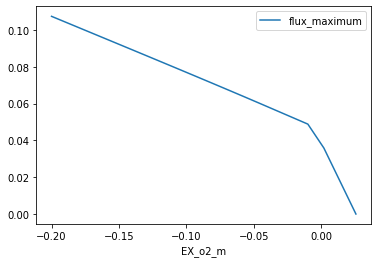

In [46]:
prod_env.plot(
    kind='line', x='EX_o2_m', y='flux_maximum');

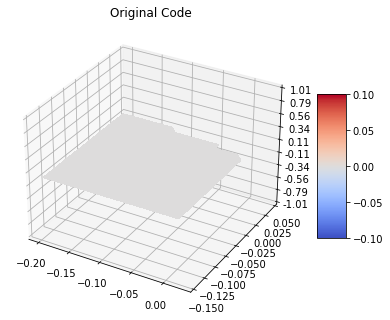

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(prod_env['EX_o2_m'], prod_env['EX_chol_m'], prod_env.mass_yield_maximum, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Original Code')
plt.show()

In [75]:
reacts=['FDH__A', 'FDH__B', 'FDH__C']

t_u=0
t_l=0

for r in com.reactions:
    if 'FDH__' in r.id:
        t_u=r.upper_bound
        t_l=r.lower_bound
        r.upper_bound = 0
        r.lower_bound = 0
        try:
            sol_i = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
            print(r.id)
            print('Zero bounds: ', r.lower_bound,r.upper_bound)
            
            if sol_i.growth_rate < goal*0.95 or sol_i.members.growth_rate['A']< goalA*0.95 or sol_i.members.growth_rate['B']< goalB*0.95 or sol_i.members.growth_rate['C']< goalC*0.95:
                temp = r.id.split('__')
                if '___' in r.id:
                    temp[0]+='_'
                    temp[1]=temp[1][1:]

                print('Growth: ', sol_i.growth_rate, sol_i.members.growth_rate['A'], sol_i.members.growth_rate['B'], sol_i.members.growth_rate['C'])
                print('Original flux: ', sol.fluxes[temp[0]][temp[1]])
                print('Flux: ', sol_i.fluxes[temp[0]][temp[1]])
                print('Original bounds: ',t_l,t_u, end='\n--------------------------------------------------->\n\n')
            else:
                print('Original bounds: ',t_l,t_u, end='\n-----------------------------\n\n')
        except:
            print('Error',temp)
            
        r.upper_bound = t_u
        r.lower_bound = t_l

FDH__A
Zero bounds:  0 0
Growth:  0.04331404913491664 0.0 0.040127553519428046 0.05324834380381367
Original flux:  0.0001853264021832582
Flux:  0.0
Original bounds:  0.0 100.0
--------------------------------------------------->

FDH__C
Zero bounds:  0 0
Growth:  0.04331404913493348 0.0 0.040127553519744084 0.053248343803607955
Original flux:  0.0010657647844483007
Flux:  0.0
Original bounds:  0.0 100.0
--------------------------------------------------->

FTHFDH__C
Zero bounds:  0 0
Growth:  0.04331404913491481 0.0 0.040127553519372514 0.05324834380385199
Original flux:  0.08677084708092252
Flux:  0.0
Original bounds:  0.0 100.0
--------------------------------------------------->

